In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [2]:
import os
import zipfile

def unzip_file(zip_filepath, dest_dir):
    # Create destination directory if it doesn't exist
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)

# Specify the directory where you want the contents of the zip file to be extracted
unzip_file("images.zip", "")


In [3]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(64, 64, 3)),
                layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
                layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
                layers.Flatten(),
                layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(latent_dim,)),
                layers.Dense(16 * 16 * 64, activation='relu'),
                layers.Reshape(target_shape=(16, 16, 64)),
                layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
                layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
                layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same'),
            ]
        )

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
      batch_size = tf.shape(mean)[0]
      generator = tf.random.Generator.from_seed(0)
      eps = generator.uniform(shape=(batch_size, self.latent_dim), dtype=tf.float32)
      return eps * tf.exp(logvar * .5) + mean



    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)
        return x_logit

In [4]:
import os

folder_name = "timelapse"

# Get the current directory
current_dir = os.getcwd()

# Path of the new folder
new_folder_path = os.path.join(current_dir, folder_name)

# Check if the folder already exists
if not os.path.exists(new_folder_path):
    # Create the folder
    os.mkdir(new_folder_path)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")


Folder 'timelapse' created successfully.


In [5]:
import tensorflow as tf
import os
import numpy as np

# Step 1: Load and preprocess the images
image_folder = "./images"
image_size = (64, 64)
image_paths = os.listdir(image_folder)
labels = []

preprocessed_images = []
for image_path in image_paths:
    image = tf.keras.preprocessing.image.load_img(
        os.path.join(image_folder, image_path),
        target_size=image_size
    )
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255  # Normalize pixel values between 0 and 1
    preprocessed_images.append(image)
    labels.append(image_path[:-4])  # Remove file extension

preprocessed_images = np.array(preprocessed_images)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
# Step 2: Prepare the training data
batch_size = 100
dataset = tf.data.Dataset.from_tensor_slices((preprocessed_images, labels))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)


In [7]:
import os

folder_path = "./images"
max_entries = 100

# Get the list of entries in the folder
entries = os.listdir(folder_path)

# Sort the entries alphabetically
entries.sort()

# Remove the excess entries
excess_entries = entries[max_entries:]

# Delete the excess entries
for entry in excess_entries:
    entry_path = os.path.join(folder_path, entry)
    if os.path.isfile(entry_path):
        os.remove(entry_path)
        print(f"File '{entry}' removed.")
    elif os.path.isdir(entry_path):
        os.rmdir(entry_path)
        print(f"Directory '{entry}' removed.")

print("Excess entries removed successfully.")


File 'chesnaught.png' removed.
File 'chespin.png' removed.
File 'chikorita.png' removed.
File 'chimchar.png' removed.
File 'chimecho.png' removed.
File 'chinchou.png' removed.
File 'chingling.png' removed.
File 'cinccino.png' removed.
File 'clamperl.png' removed.
File 'clauncher.png' removed.
File 'clawitzer.png' removed.
File 'claydol.png' removed.
File 'clefable.png' removed.
File 'clefairy.png' removed.
File 'cleffa.png' removed.
File 'cloyster.png' removed.
File 'cobalion.png' removed.
File 'cofagrigus.png' removed.
File 'combee.png' removed.
File 'combusken.png' removed.
File 'comfey.jpg' removed.
File 'conkeldurr.png' removed.
File 'corphish.png' removed.
File 'corsola.png' removed.
File 'cosmoem.jpg' removed.
File 'cosmog.jpg' removed.
File 'cottonee.png' removed.
File 'crabominable.jpg' removed.
File 'crabrawler.jpg' removed.
File 'cradily.png' removed.
File 'cranidos.png' removed.
File 'crawdaunt.png' removed.
File 'cresselia.png' removed.
File 'croagunk.png' removed.
File 'cr

In [8]:
# Step 3: Define the loss function
mse_loss = tf.keras.losses.MeanSquaredError()

In [9]:


def preprocess_image(image_path):
    # Load image
    img = kimage.load_img(image_path, target_size=(64, 64))
    # Convert to array and rescale pixel values to range [-1, 1]
    img = (kimage.img_to_array(img) - 127.5) / 127.5
    # Add a batch dimension
    img = np.expand_dims(img, axis=0)
    return img


def deprocess_image(img):
    # Undo the rescaling
    img = (img * 127.5) + 127.5
    # Remove batch dimension
    img = np.squeeze(img, axis=0)
    # Convert to uint8 pixel values
    return tf.cast(img, tf.uint8)

def interpolate(model, image1, image2, num_steps=10):
    image1 = preprocess_image(image1)
    image2 = preprocess_image(image2)

    z1, _ = model.encode(image1)
    z2, _ = model.encode(image2)

    # Generate intermediate representations
    alphas = np.linspace(0, 1, num_steps)
    intermediate_zs = [z1 * (1 - alpha) + z2 * alpha for alpha in alphas]

    # Decode the intermediate representations to images
    intermediate_images = []
    for z in intermediate_zs:
        intermediate_img = deprocess_image(model.decode(z))
        intermediate_images.append(intermediate_img)

    return intermediate_images

Epoch 1/140
Batch Loss: 0.2216
Batch Loss: 0.2153
Batch Loss: 0.1975
Batch Loss: 0.1739
Batch Loss: 0.1293
Batch Loss: 0.0774
Batch Loss: 0.0766
Batch Loss: 0.0787
Batch Loss: 0.0500


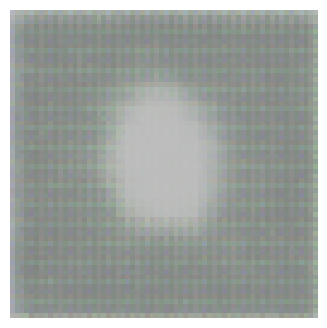

Epoch 2/140
Batch Loss: 0.0742
Batch Loss: 0.0676
Batch Loss: 0.0763
Batch Loss: 0.0625
Batch Loss: 0.0622
Batch Loss: 0.0607
Batch Loss: 0.0543
Batch Loss: 0.0641
Batch Loss: 0.0343


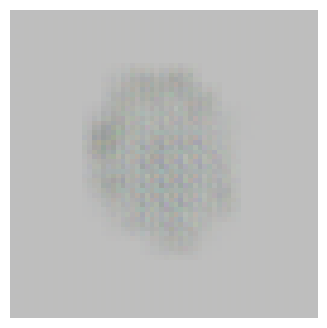

Epoch 3/140
Batch Loss: 0.0699
Batch Loss: 0.0580
Batch Loss: 0.0500
Batch Loss: 0.0499
Batch Loss: 0.0587
Batch Loss: 0.0615
Batch Loss: 0.0551
Batch Loss: 0.0654
Batch Loss: 0.0567


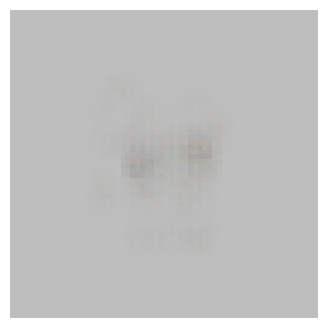

Epoch 4/140
Batch Loss: 0.0557
Batch Loss: 0.0548
Batch Loss: 0.0562
Batch Loss: 0.0540
Batch Loss: 0.0580
Batch Loss: 0.0584
Batch Loss: 0.0536
Batch Loss: 0.0501
Batch Loss: 0.0594


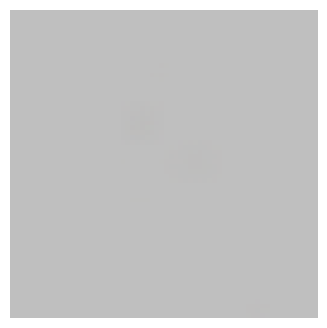

Epoch 5/140
Batch Loss: 0.0468
Batch Loss: 0.0571
Batch Loss: 0.0533
Batch Loss: 0.0516
Batch Loss: 0.0526
Batch Loss: 0.0539
Batch Loss: 0.0590
Batch Loss: 0.0544
Batch Loss: 0.0715


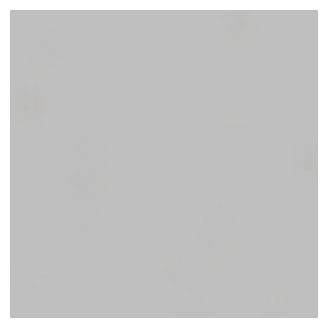

Epoch 6/140
Batch Loss: 0.0525
Batch Loss: 0.0618
Batch Loss: 0.0570
Batch Loss: 0.0472
Batch Loss: 0.0555
Batch Loss: 0.0523
Batch Loss: 0.0496
Batch Loss: 0.0478
Batch Loss: 0.0482


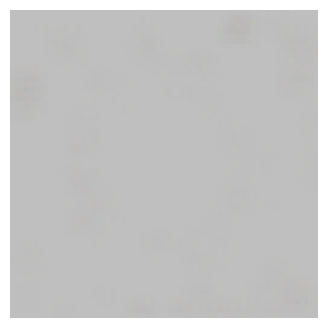

Epoch 7/140
Batch Loss: 0.0490
Batch Loss: 0.0574
Batch Loss: 0.0530
Batch Loss: 0.0540
Batch Loss: 0.0518
Batch Loss: 0.0429
Batch Loss: 0.0584
Batch Loss: 0.0530
Batch Loss: 0.0351


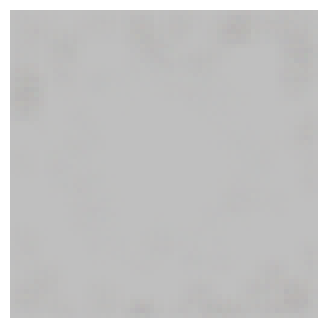

Epoch 8/140
Batch Loss: 0.0550
Batch Loss: 0.0520
Batch Loss: 0.0433
Batch Loss: 0.0547
Batch Loss: 0.0478
Batch Loss: 0.0552
Batch Loss: 0.0538
Batch Loss: 0.0525
Batch Loss: 0.0451


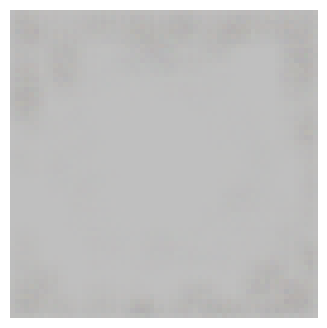

Epoch 9/140
Batch Loss: 0.0520
Batch Loss: 0.0498
Batch Loss: 0.0574
Batch Loss: 0.0469
Batch Loss: 0.0536
Batch Loss: 0.0499
Batch Loss: 0.0479
Batch Loss: 0.0546
Batch Loss: 0.0270


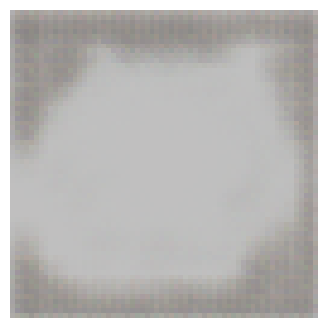

Epoch 10/140
Batch Loss: 0.0565
Batch Loss: 0.0451
Batch Loss: 0.0502
Batch Loss: 0.0457
Batch Loss: 0.0556
Batch Loss: 0.0533
Batch Loss: 0.0443
Batch Loss: 0.0535
Batch Loss: 0.0841


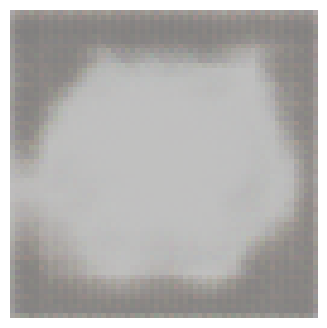

Epoch 11/140
Batch Loss: 0.0470
Batch Loss: 0.0469
Batch Loss: 0.0439
Batch Loss: 0.0548
Batch Loss: 0.0523
Batch Loss: 0.0564
Batch Loss: 0.0499
Batch Loss: 0.0537
Batch Loss: 0.0458


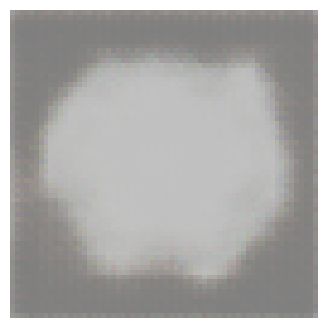

Epoch 12/140
Batch Loss: 0.0498
Batch Loss: 0.0478
Batch Loss: 0.0512
Batch Loss: 0.0474
Batch Loss: 0.0494
Batch Loss: 0.0548
Batch Loss: 0.0536
Batch Loss: 0.0487
Batch Loss: 0.0265


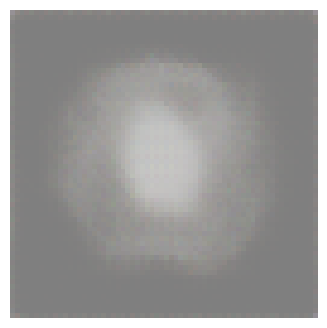

Epoch 13/140
Batch Loss: 0.0520
Batch Loss: 0.0470
Batch Loss: 0.0532
Batch Loss: 0.0574
Batch Loss: 0.0440
Batch Loss: 0.0501
Batch Loss: 0.0442
Batch Loss: 0.0463
Batch Loss: 0.0453


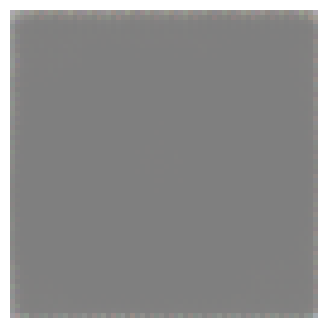

Epoch 14/140
Batch Loss: 0.0538
Batch Loss: 0.0438
Batch Loss: 0.0437
Batch Loss: 0.0484
Batch Loss: 0.0458
Batch Loss: 0.0524
Batch Loss: 0.0473
Batch Loss: 0.0471
Batch Loss: 0.0563


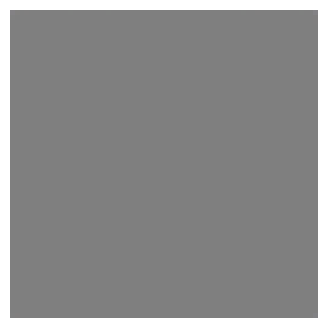

Epoch 15/140
Batch Loss: 0.0430
Batch Loss: 0.0468
Batch Loss: 0.0516
Batch Loss: 0.0435
Batch Loss: 0.0432
Batch Loss: 0.0528
Batch Loss: 0.0473
Batch Loss: 0.0459
Batch Loss: 0.0417


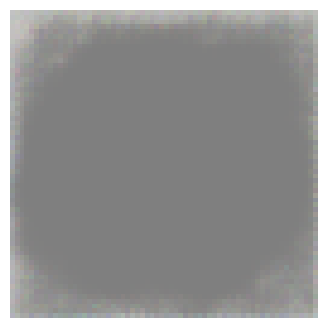

Epoch 16/140
Batch Loss: 0.0492
Batch Loss: 0.0366
Batch Loss: 0.0443
Batch Loss: 0.0409
Batch Loss: 0.0468
Batch Loss: 0.0596
Batch Loss: 0.0362
Batch Loss: 0.0516
Batch Loss: 0.0168


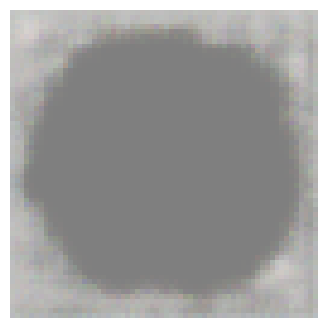

Epoch 17/140
Batch Loss: 0.0428
Batch Loss: 0.0486
Batch Loss: 0.0431
Batch Loss: 0.0421
Batch Loss: 0.0435
Batch Loss: 0.0373
Batch Loss: 0.0450
Batch Loss: 0.0529
Batch Loss: 0.0201


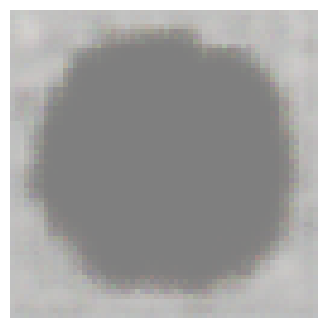

Epoch 18/140
Batch Loss: 0.0437
Batch Loss: 0.0476
Batch Loss: 0.0503
Batch Loss: 0.0419
Batch Loss: 0.0355
Batch Loss: 0.0416
Batch Loss: 0.0450
Batch Loss: 0.0404
Batch Loss: 0.0266


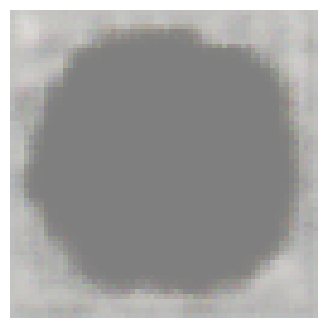

Epoch 19/140
Batch Loss: 0.0353
Batch Loss: 0.0401
Batch Loss: 0.0367
Batch Loss: 0.0370
Batch Loss: 0.0464
Batch Loss: 0.0446
Batch Loss: 0.0416
Batch Loss: 0.0326
Batch Loss: 0.0837


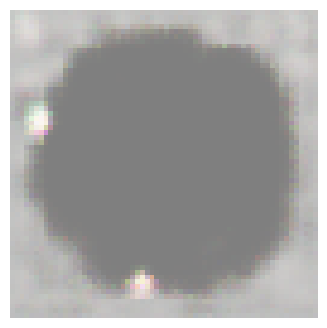

Epoch 20/140
Batch Loss: 0.0398
Batch Loss: 0.0389
Batch Loss: 0.0394
Batch Loss: 0.0412
Batch Loss: 0.0344
Batch Loss: 0.0385
Batch Loss: 0.0302
Batch Loss: 0.0383
Batch Loss: 0.0174


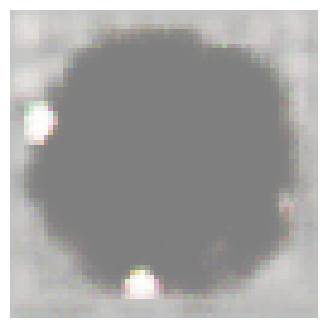

Epoch 21/140
Batch Loss: 0.0395
Batch Loss: 0.0370
Batch Loss: 0.0285
Batch Loss: 0.0352
Batch Loss: 0.0319
Batch Loss: 0.0411
Batch Loss: 0.0310
Batch Loss: 0.0320
Batch Loss: 0.0319


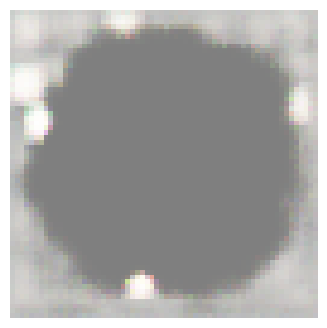

Epoch 22/140
Batch Loss: 0.0336
Batch Loss: 0.0343
Batch Loss: 0.0344
Batch Loss: 0.0328
Batch Loss: 0.0295
Batch Loss: 0.0311
Batch Loss: 0.0301
Batch Loss: 0.0315
Batch Loss: 0.0188


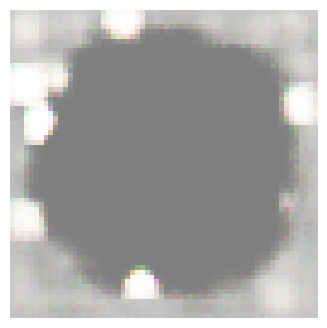

Epoch 23/140
Batch Loss: 0.0250
Batch Loss: 0.0307
Batch Loss: 0.0258
Batch Loss: 0.0316
Batch Loss: 0.0340
Batch Loss: 0.0331
Batch Loss: 0.0270
Batch Loss: 0.0287
Batch Loss: 0.0242


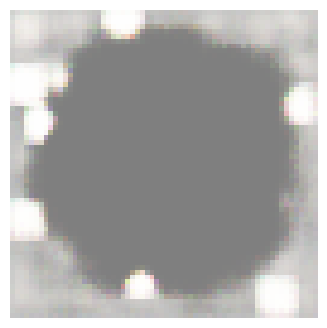

Epoch 24/140
Batch Loss: 0.0350
Batch Loss: 0.0264
Batch Loss: 0.0245
Batch Loss: 0.0251
Batch Loss: 0.0287
Batch Loss: 0.0258
Batch Loss: 0.0280
Batch Loss: 0.0236
Batch Loss: 0.0173


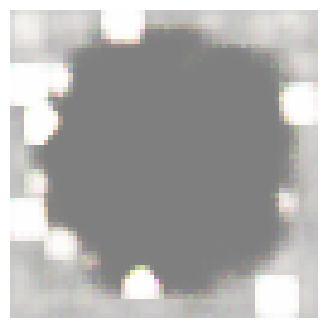

Epoch 25/140
Batch Loss: 0.0267
Batch Loss: 0.0246
Batch Loss: 0.0251
Batch Loss: 0.0261
Batch Loss: 0.0250
Batch Loss: 0.0242
Batch Loss: 0.0231
Batch Loss: 0.0210
Batch Loss: 0.0242


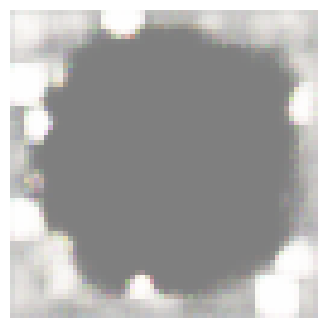

Epoch 26/140
Batch Loss: 0.0213
Batch Loss: 0.0225
Batch Loss: 0.0235
Batch Loss: 0.0217
Batch Loss: 0.0249
Batch Loss: 0.0230
Batch Loss: 0.0238
Batch Loss: 0.0201
Batch Loss: 0.0243


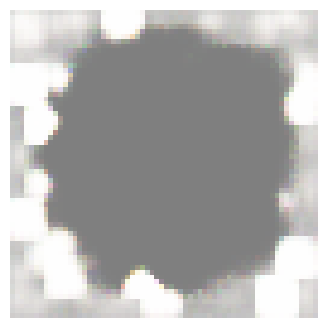

Epoch 27/140
Batch Loss: 0.0217
Batch Loss: 0.0212
Batch Loss: 0.0175
Batch Loss: 0.0185
Batch Loss: 0.0235
Batch Loss: 0.0209
Batch Loss: 0.0209
Batch Loss: 0.0230
Batch Loss: 0.0178


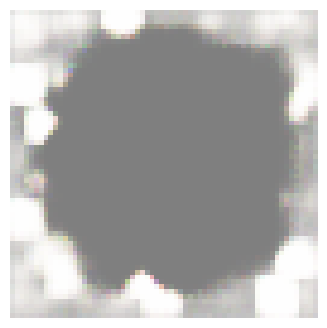

Epoch 28/140
Batch Loss: 0.0191
Batch Loss: 0.0203
Batch Loss: 0.0195
Batch Loss: 0.0223
Batch Loss: 0.0181
Batch Loss: 0.0197
Batch Loss: 0.0170
Batch Loss: 0.0190
Batch Loss: 0.0177


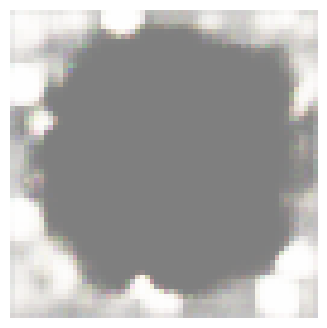

Epoch 29/140
Batch Loss: 0.0169
Batch Loss: 0.0175
Batch Loss: 0.0186
Batch Loss: 0.0167
Batch Loss: 0.0190
Batch Loss: 0.0187
Batch Loss: 0.0182
Batch Loss: 0.0177
Batch Loss: 0.0205


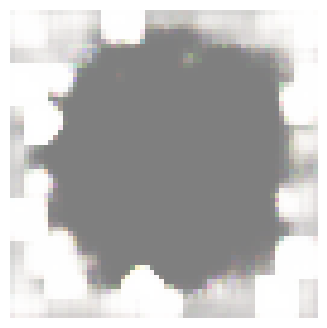

Epoch 30/140
Batch Loss: 0.0222
Batch Loss: 0.0207
Batch Loss: 0.0282
Batch Loss: 0.0202
Batch Loss: 0.0225
Batch Loss: 0.0213
Batch Loss: 0.0212
Batch Loss: 0.0208
Batch Loss: 0.0155


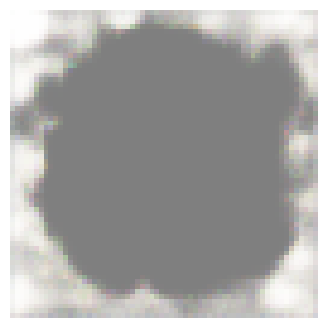

Epoch 31/140
Batch Loss: 0.0177
Batch Loss: 0.0232
Batch Loss: 0.0191
Batch Loss: 0.0213
Batch Loss: 0.0181
Batch Loss: 0.0185
Batch Loss: 0.0184
Batch Loss: 0.0181
Batch Loss: 0.0184


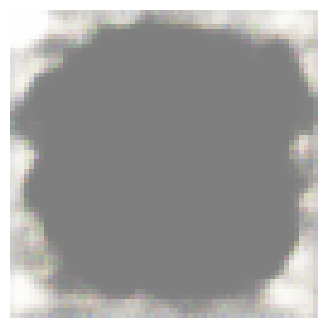

Epoch 32/140
Batch Loss: 0.0182
Batch Loss: 0.0189
Batch Loss: 0.0177
Batch Loss: 0.0189
Batch Loss: 0.0160
Batch Loss: 0.0168
Batch Loss: 0.0212
Batch Loss: 0.0174
Batch Loss: 0.0113


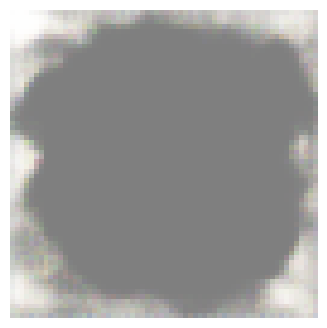

Epoch 33/140
Batch Loss: 0.0152
Batch Loss: 0.0196
Batch Loss: 0.0153
Batch Loss: 0.0161
Batch Loss: 0.0160
Batch Loss: 0.0169
Batch Loss: 0.0189
Batch Loss: 0.0162
Batch Loss: 0.0170


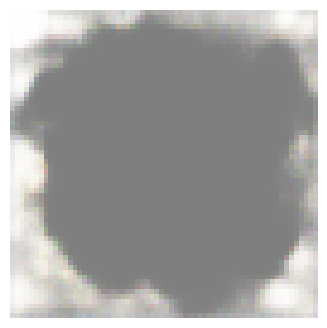

Epoch 34/140
Batch Loss: 0.0150
Batch Loss: 0.0171
Batch Loss: 0.0155
Batch Loss: 0.0167
Batch Loss: 0.0157
Batch Loss: 0.0179
Batch Loss: 0.0162
Batch Loss: 0.0144
Batch Loss: 0.0187


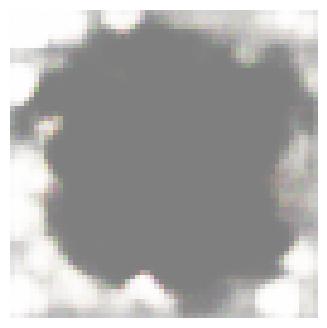

Epoch 35/140
Batch Loss: 0.0148
Batch Loss: 0.0169
Batch Loss: 0.0168
Batch Loss: 0.0195
Batch Loss: 0.0172
Batch Loss: 0.0183
Batch Loss: 0.0176
Batch Loss: 0.0147
Batch Loss: 0.0154


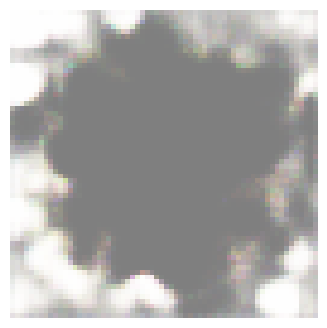

Epoch 36/140
Batch Loss: 0.0151
Batch Loss: 0.0171
Batch Loss: 0.0155
Batch Loss: 0.0160
Batch Loss: 0.0154
Batch Loss: 0.0189
Batch Loss: 0.0158
Batch Loss: 0.0172
Batch Loss: 0.0105


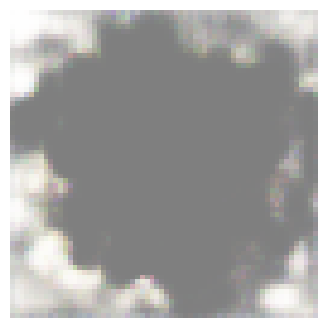

Epoch 37/140
Batch Loss: 0.0148
Batch Loss: 0.0146
Batch Loss: 0.0148
Batch Loss: 0.0172
Batch Loss: 0.0159
Batch Loss: 0.0167
Batch Loss: 0.0140
Batch Loss: 0.0153
Batch Loss: 0.0154


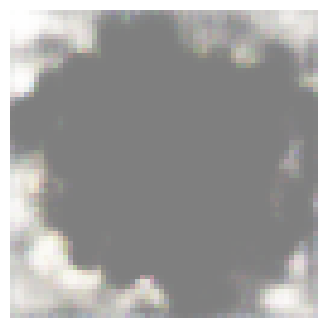

Epoch 38/140
Batch Loss: 0.0157
Batch Loss: 0.0133
Batch Loss: 0.0150
Batch Loss: 0.0142
Batch Loss: 0.0153
Batch Loss: 0.0140
Batch Loss: 0.0155
Batch Loss: 0.0161
Batch Loss: 0.0149


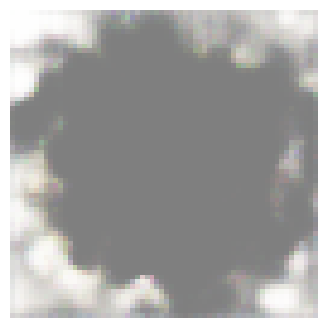

Epoch 39/140
Batch Loss: 0.0148
Batch Loss: 0.0144
Batch Loss: 0.0155
Batch Loss: 0.0137
Batch Loss: 0.0145
Batch Loss: 0.0152
Batch Loss: 0.0142
Batch Loss: 0.0137
Batch Loss: 0.0118


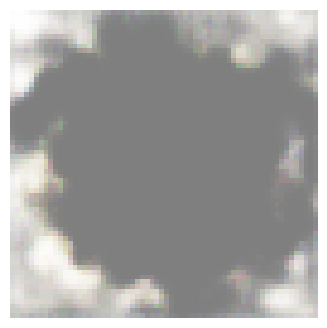

Epoch 40/140
Batch Loss: 0.0156
Batch Loss: 0.0148
Batch Loss: 0.0146
Batch Loss: 0.0148
Batch Loss: 0.0144
Batch Loss: 0.0150
Batch Loss: 0.0147
Batch Loss: 0.0151
Batch Loss: 0.0130


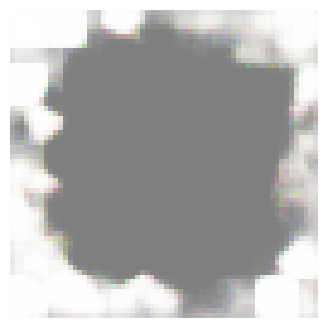

Epoch 41/140
Batch Loss: 0.0143
Batch Loss: 0.0143
Batch Loss: 0.0148
Batch Loss: 0.0142
Batch Loss: 0.0146
Batch Loss: 0.0143
Batch Loss: 0.0143
Batch Loss: 0.0148
Batch Loss: 0.0131


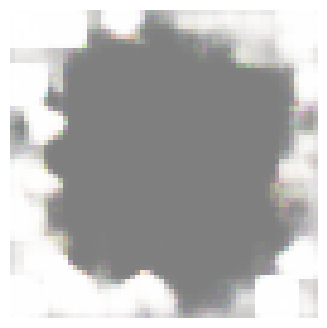

Epoch 42/140
Batch Loss: 0.0127
Batch Loss: 0.0129
Batch Loss: 0.0129
Batch Loss: 0.0153
Batch Loss: 0.0145
Batch Loss: 0.0137
Batch Loss: 0.0159
Batch Loss: 0.0142
Batch Loss: 0.0111


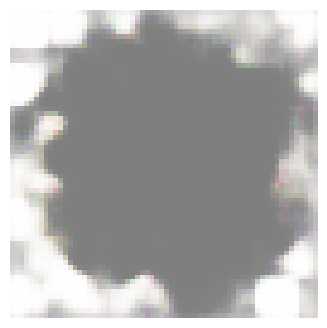

Epoch 43/140
Batch Loss: 0.0144
Batch Loss: 0.0129
Batch Loss: 0.0140
Batch Loss: 0.0133
Batch Loss: 0.0133
Batch Loss: 0.0131
Batch Loss: 0.0128
Batch Loss: 0.0130
Batch Loss: 0.0159


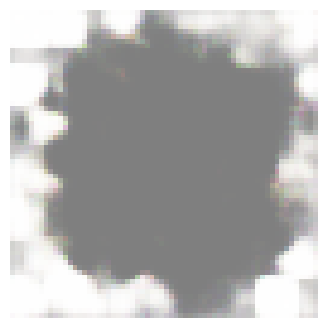

Epoch 44/140
Batch Loss: 0.0122
Batch Loss: 0.0138
Batch Loss: 0.0140
Batch Loss: 0.0136
Batch Loss: 0.0132
Batch Loss: 0.0136
Batch Loss: 0.0147
Batch Loss: 0.0121
Batch Loss: 0.0127


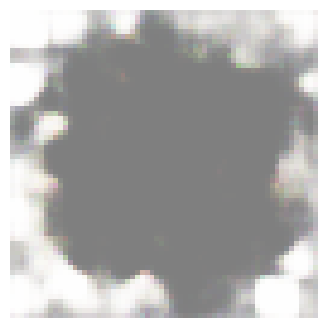

Epoch 45/140
Batch Loss: 0.0122
Batch Loss: 0.0135
Batch Loss: 0.0130
Batch Loss: 0.0120
Batch Loss: 0.0136
Batch Loss: 0.0126
Batch Loss: 0.0135
Batch Loss: 0.0136
Batch Loss: 0.0141


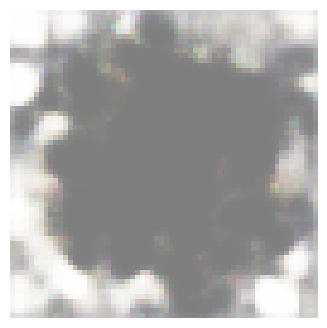

Epoch 46/140
Batch Loss: 0.0128
Batch Loss: 0.0125
Batch Loss: 0.0124
Batch Loss: 0.0116
Batch Loss: 0.0125
Batch Loss: 0.0125
Batch Loss: 0.0128
Batch Loss: 0.0141
Batch Loss: 0.0102


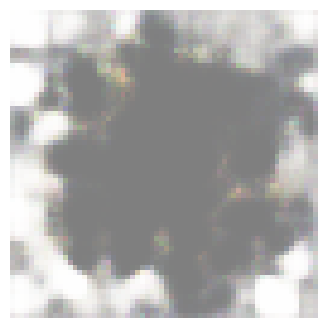

Epoch 47/140
Batch Loss: 0.0115
Batch Loss: 0.0121
Batch Loss: 0.0131
Batch Loss: 0.0135
Batch Loss: 0.0117
Batch Loss: 0.0115
Batch Loss: 0.0123
Batch Loss: 0.0118
Batch Loss: 0.0139


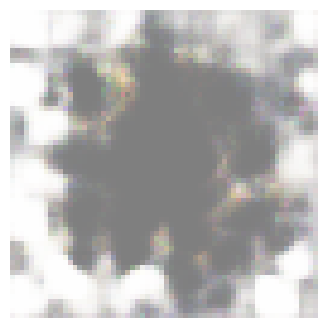

Epoch 48/140
Batch Loss: 0.0120
Batch Loss: 0.0134
Batch Loss: 0.0130
Batch Loss: 0.0109
Batch Loss: 0.0128
Batch Loss: 0.0126
Batch Loss: 0.0114
Batch Loss: 0.0126
Batch Loss: 0.0096


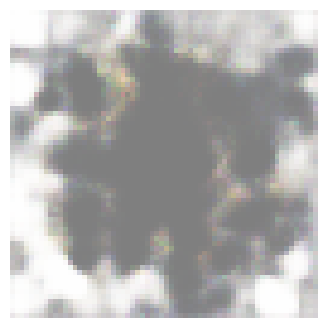

Epoch 49/140
Batch Loss: 0.0124
Batch Loss: 0.0113
Batch Loss: 0.0126
Batch Loss: 0.0117
Batch Loss: 0.0130
Batch Loss: 0.0110
Batch Loss: 0.0119
Batch Loss: 0.0123
Batch Loss: 0.0091


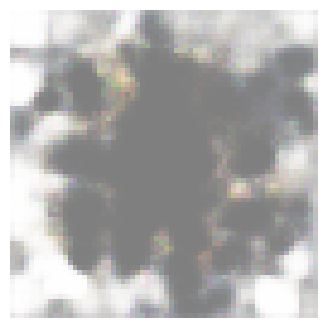

Epoch 50/140
Batch Loss: 0.0117
Batch Loss: 0.0122
Batch Loss: 0.0119
Batch Loss: 0.0116
Batch Loss: 0.0112
Batch Loss: 0.0116
Batch Loss: 0.0115
Batch Loss: 0.0116
Batch Loss: 0.0105


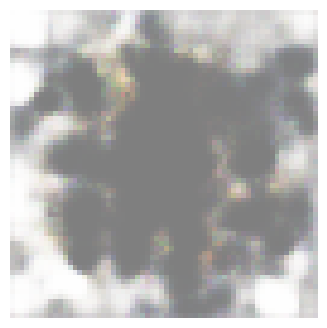

Epoch 51/140
Batch Loss: 0.0120
Batch Loss: 0.0106
Batch Loss: 0.0113
Batch Loss: 0.0107
Batch Loss: 0.0110
Batch Loss: 0.0117
Batch Loss: 0.0115
Batch Loss: 0.0116
Batch Loss: 0.0104


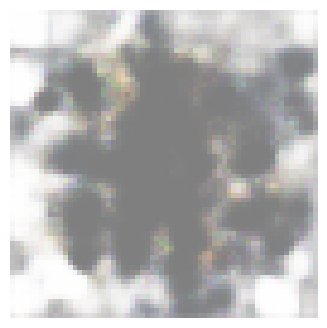

Epoch 52/140
Batch Loss: 0.0113
Batch Loss: 0.0109
Batch Loss: 0.0117
Batch Loss: 0.0108
Batch Loss: 0.0111
Batch Loss: 0.0103
Batch Loss: 0.0112
Batch Loss: 0.0107
Batch Loss: 0.0109


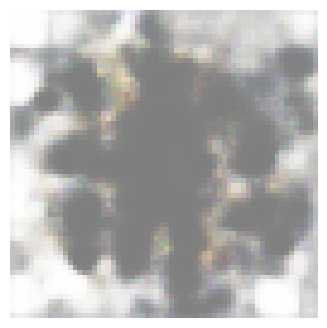

Epoch 53/140
Batch Loss: 0.0102
Batch Loss: 0.0110
Batch Loss: 0.0111
Batch Loss: 0.0108
Batch Loss: 0.0107
Batch Loss: 0.0113
Batch Loss: 0.0106
Batch Loss: 0.0107
Batch Loss: 0.0100


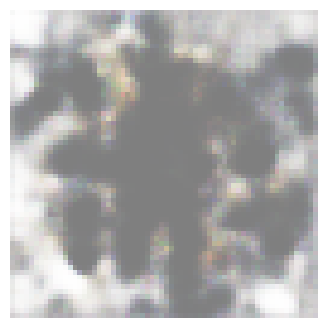

Epoch 54/140
Batch Loss: 0.0102
Batch Loss: 0.0100
Batch Loss: 0.0109
Batch Loss: 0.0103
Batch Loss: 0.0109
Batch Loss: 0.0107
Batch Loss: 0.0112
Batch Loss: 0.0109
Batch Loss: 0.0095


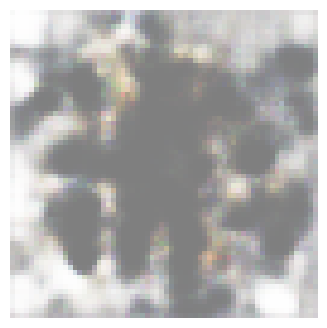

Epoch 55/140
Batch Loss: 0.0096
Batch Loss: 0.0098
Batch Loss: 0.0102
Batch Loss: 0.0102
Batch Loss: 0.0107
Batch Loss: 0.0111
Batch Loss: 0.0116
Batch Loss: 0.0108
Batch Loss: 0.0108


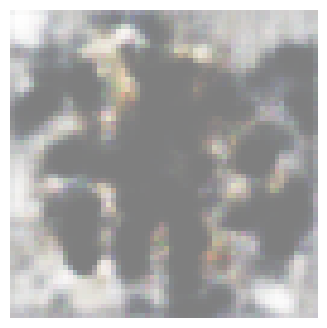

Epoch 56/140
Batch Loss: 0.0101
Batch Loss: 0.0101
Batch Loss: 0.0098
Batch Loss: 0.0105
Batch Loss: 0.0103
Batch Loss: 0.0115
Batch Loss: 0.0100
Batch Loss: 0.0106
Batch Loss: 0.0117


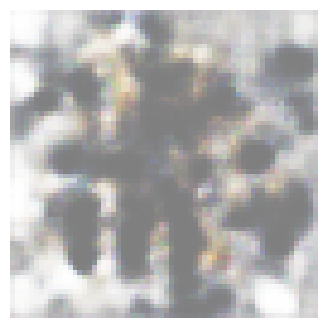

Epoch 57/140
Batch Loss: 0.0097
Batch Loss: 0.0103
Batch Loss: 0.0105
Batch Loss: 0.0103
Batch Loss: 0.0107
Batch Loss: 0.0108
Batch Loss: 0.0105
Batch Loss: 0.0107
Batch Loss: 0.0118


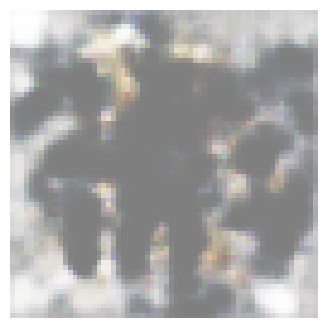

Epoch 58/140
Batch Loss: 0.0105
Batch Loss: 0.0101
Batch Loss: 0.0104
Batch Loss: 0.0105
Batch Loss: 0.0106
Batch Loss: 0.0095
Batch Loss: 0.0109
Batch Loss: 0.0098
Batch Loss: 0.0089


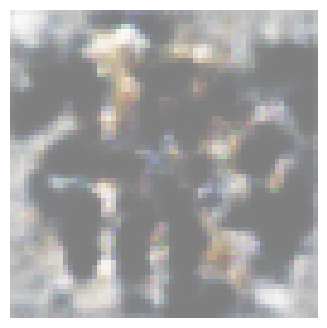

Epoch 59/140
Batch Loss: 0.0105
Batch Loss: 0.0099
Batch Loss: 0.0102
Batch Loss: 0.0100
Batch Loss: 0.0104
Batch Loss: 0.0095
Batch Loss: 0.0107
Batch Loss: 0.0107
Batch Loss: 0.0082


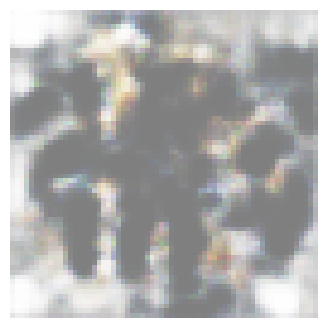

Epoch 60/140
Batch Loss: 0.0097
Batch Loss: 0.0100
Batch Loss: 0.0100
Batch Loss: 0.0094
Batch Loss: 0.0103
Batch Loss: 0.0101
Batch Loss: 0.0100
Batch Loss: 0.0098
Batch Loss: 0.0104


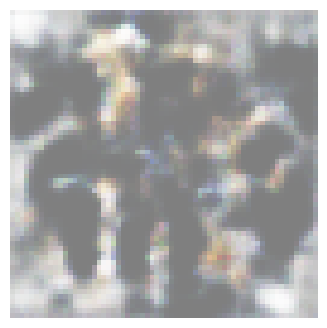

Epoch 61/140
Batch Loss: 0.0104
Batch Loss: 0.0098
Batch Loss: 0.0096
Batch Loss: 0.0098
Batch Loss: 0.0091
Batch Loss: 0.0095
Batch Loss: 0.0095
Batch Loss: 0.0096
Batch Loss: 0.0093


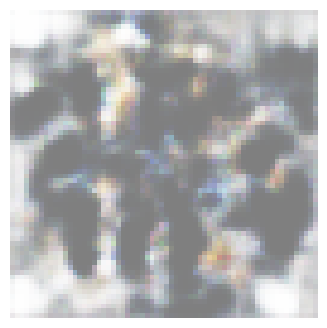

Epoch 62/140
Batch Loss: 0.0094
Batch Loss: 0.0099
Batch Loss: 0.0088
Batch Loss: 0.0104
Batch Loss: 0.0092
Batch Loss: 0.0092
Batch Loss: 0.0095
Batch Loss: 0.0100
Batch Loss: 0.0107


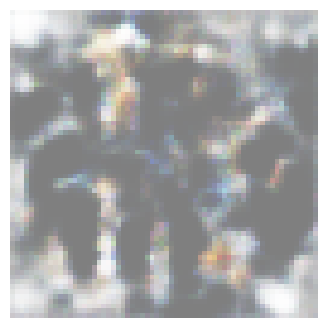

Epoch 63/140
Batch Loss: 0.0096
Batch Loss: 0.0092
Batch Loss: 0.0091
Batch Loss: 0.0092
Batch Loss: 0.0090
Batch Loss: 0.0095
Batch Loss: 0.0102
Batch Loss: 0.0090
Batch Loss: 0.0083


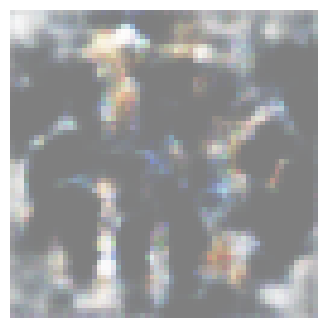

Epoch 64/140
Batch Loss: 0.0094
Batch Loss: 0.0091
Batch Loss: 0.0083
Batch Loss: 0.0089
Batch Loss: 0.0088
Batch Loss: 0.0097
Batch Loss: 0.0093
Batch Loss: 0.0094
Batch Loss: 0.0081


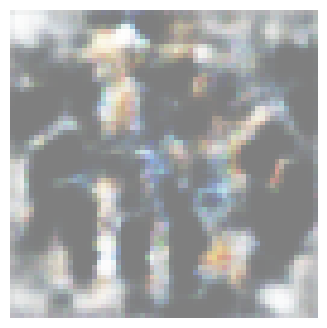

Epoch 65/140
Batch Loss: 0.0100
Batch Loss: 0.0092
Batch Loss: 0.0092
Batch Loss: 0.0080
Batch Loss: 0.0088
Batch Loss: 0.0088
Batch Loss: 0.0086
Batch Loss: 0.0087
Batch Loss: 0.0067


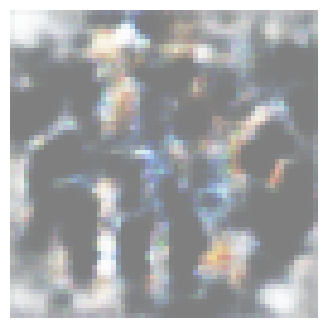

Epoch 66/140
Batch Loss: 0.0088
Batch Loss: 0.0089
Batch Loss: 0.0078
Batch Loss: 0.0084
Batch Loss: 0.0088
Batch Loss: 0.0090
Batch Loss: 0.0084
Batch Loss: 0.0088
Batch Loss: 0.0106


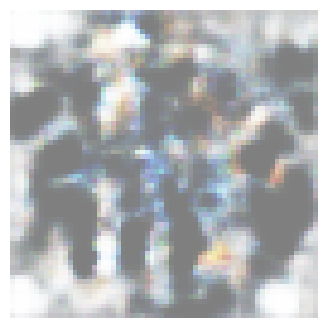

Epoch 67/140
Batch Loss: 0.0090
Batch Loss: 0.0090
Batch Loss: 0.0086
Batch Loss: 0.0085
Batch Loss: 0.0089
Batch Loss: 0.0087
Batch Loss: 0.0117
Batch Loss: 0.0128
Batch Loss: 0.0149


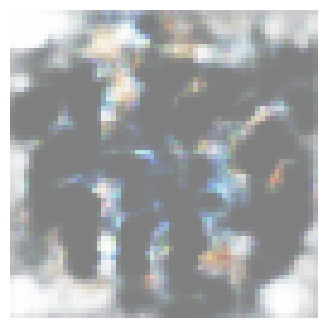

Epoch 68/140
Batch Loss: 0.0138
Batch Loss: 0.0143
Batch Loss: 0.0129
Batch Loss: 0.0150
Batch Loss: 0.0127
Batch Loss: 0.0133
Batch Loss: 0.0150
Batch Loss: 0.0138
Batch Loss: 0.0118


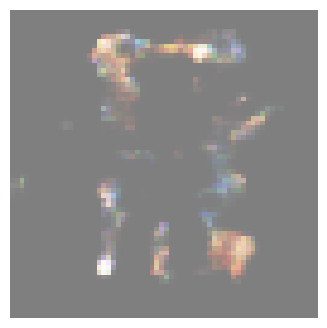

Epoch 69/140
Batch Loss: 0.0138
Batch Loss: 0.0120
Batch Loss: 0.0128
Batch Loss: 0.0126
Batch Loss: 0.0119
Batch Loss: 0.0123
Batch Loss: 0.0118
Batch Loss: 0.0136
Batch Loss: 0.0143


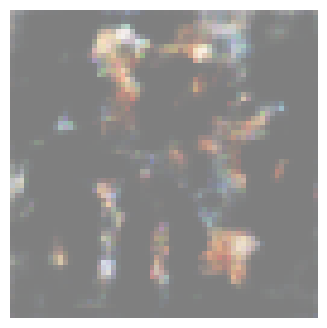

Epoch 70/140
Batch Loss: 0.0115
Batch Loss: 0.0148
Batch Loss: 0.0104
Batch Loss: 0.0122
Batch Loss: 0.0129
Batch Loss: 0.0109
Batch Loss: 0.0123
Batch Loss: 0.0116
Batch Loss: 0.0101


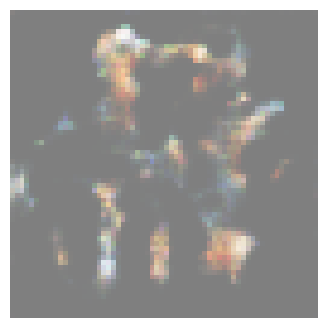

Epoch 71/140
Batch Loss: 0.0118
Batch Loss: 0.0106
Batch Loss: 0.0105
Batch Loss: 0.0109
Batch Loss: 0.0102
Batch Loss: 0.0099
Batch Loss: 0.0104
Batch Loss: 0.0111
Batch Loss: 0.0186


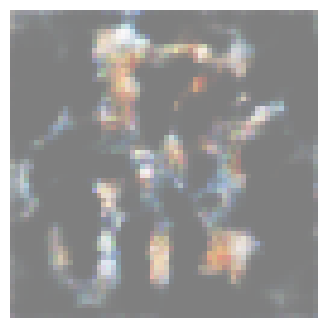

Epoch 72/140
Batch Loss: 0.0107
Batch Loss: 0.0102
Batch Loss: 0.0097
Batch Loss: 0.0097
Batch Loss: 0.0106
Batch Loss: 0.0098
Batch Loss: 0.0095
Batch Loss: 0.0109
Batch Loss: 0.0106


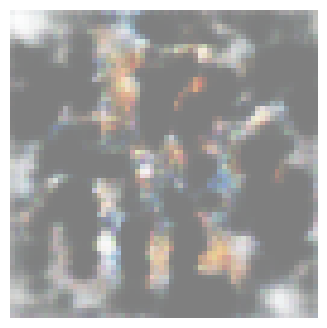

Epoch 73/140
Batch Loss: 0.0098
Batch Loss: 0.0098
Batch Loss: 0.0096
Batch Loss: 0.0088
Batch Loss: 0.0100
Batch Loss: 0.0099
Batch Loss: 0.0088
Batch Loss: 0.0091
Batch Loss: 0.0105


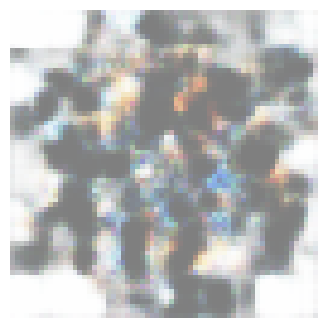

Epoch 74/140
Batch Loss: 0.0117
Batch Loss: 0.0114
Batch Loss: 0.0151
Batch Loss: 0.0117
Batch Loss: 0.0128
Batch Loss: 0.0145
Batch Loss: 0.0123
Batch Loss: 0.0125
Batch Loss: 0.0167


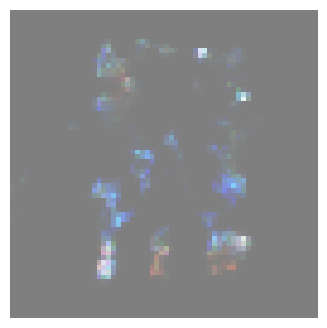

Epoch 75/140
Batch Loss: 0.0127
Batch Loss: 0.0116
Batch Loss: 0.0181
Batch Loss: 0.0131
Batch Loss: 0.0108
Batch Loss: 0.0110
Batch Loss: 0.0126
Batch Loss: 0.0110
Batch Loss: 0.0098


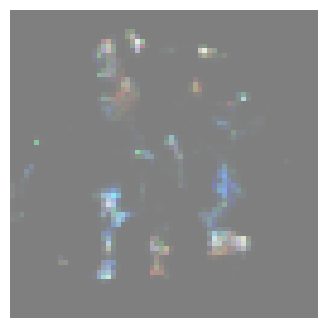

Epoch 76/140
Batch Loss: 0.0109
Batch Loss: 0.0142
Batch Loss: 0.0121
Batch Loss: 0.0115
Batch Loss: 0.0106
Batch Loss: 0.0106
Batch Loss: 0.0127
Batch Loss: 0.0120
Batch Loss: 0.0095


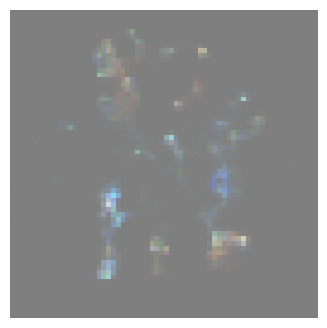

Epoch 77/140
Batch Loss: 0.0144
Batch Loss: 0.0099
Batch Loss: 0.0109
Batch Loss: 0.0095
Batch Loss: 0.0128
Batch Loss: 0.0116
Batch Loss: 0.0127
Batch Loss: 0.0116
Batch Loss: 0.0085


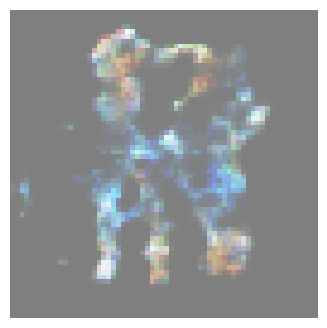

Epoch 78/140
Batch Loss: 0.0110
Batch Loss: 0.0106
Batch Loss: 0.0111
Batch Loss: 0.0107
Batch Loss: 0.0094
Batch Loss: 0.0110
Batch Loss: 0.0120
Batch Loss: 0.0095
Batch Loss: 0.0106


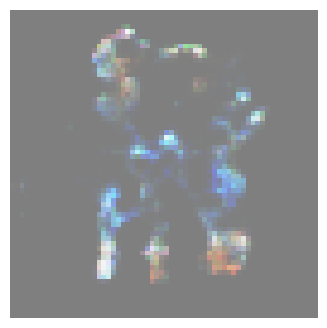

Epoch 79/140
Batch Loss: 0.0105
Batch Loss: 0.0094
Batch Loss: 0.0094
Batch Loss: 0.0118
Batch Loss: 0.0105
Batch Loss: 0.0092
Batch Loss: 0.0107
Batch Loss: 0.0081
Batch Loss: 0.0088


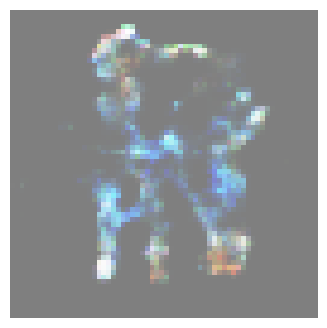

Epoch 80/140
Batch Loss: 0.0093
Batch Loss: 0.0089
Batch Loss: 0.0088
Batch Loss: 0.0096
Batch Loss: 0.0092
Batch Loss: 0.0107
Batch Loss: 0.0088
Batch Loss: 0.0097
Batch Loss: 0.0099


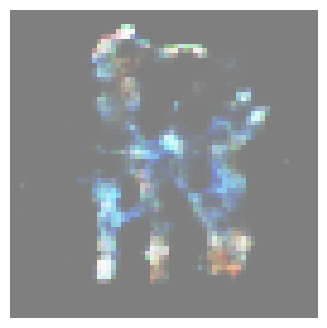

Epoch 81/140
Batch Loss: 0.0092
Batch Loss: 0.0089
Batch Loss: 0.0100
Batch Loss: 0.0100
Batch Loss: 0.0087
Batch Loss: 0.0086
Batch Loss: 0.0082
Batch Loss: 0.0075
Batch Loss: 0.0086


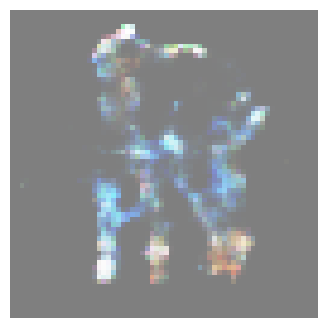

Epoch 82/140
Batch Loss: 0.0078
Batch Loss: 0.0078
Batch Loss: 0.0083
Batch Loss: 0.0093
Batch Loss: 0.0084
Batch Loss: 0.0085
Batch Loss: 0.0091
Batch Loss: 0.0083
Batch Loss: 0.0111


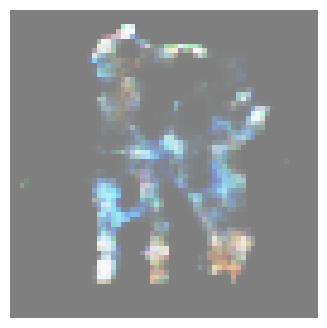

Epoch 83/140
Batch Loss: 0.0087
Batch Loss: 0.0077
Batch Loss: 0.0085
Batch Loss: 0.0076
Batch Loss: 0.0084
Batch Loss: 0.0076
Batch Loss: 0.0081
Batch Loss: 0.0075
Batch Loss: 0.0067


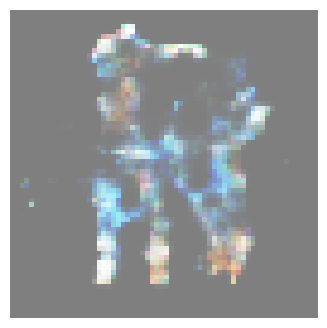

Epoch 84/140
Batch Loss: 0.0077
Batch Loss: 0.0078
Batch Loss: 0.0074
Batch Loss: 0.0077
Batch Loss: 0.0074
Batch Loss: 0.0078
Batch Loss: 0.0073
Batch Loss: 0.0080
Batch Loss: 0.0074


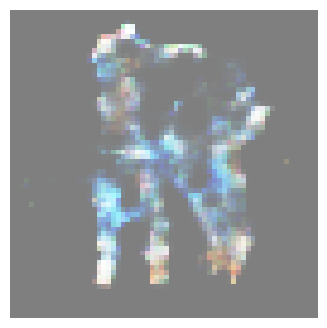

Epoch 85/140
Batch Loss: 0.0072
Batch Loss: 0.0070
Batch Loss: 0.0073
Batch Loss: 0.0075
Batch Loss: 0.0079
Batch Loss: 0.0075
Batch Loss: 0.0078
Batch Loss: 0.0074
Batch Loss: 0.0071


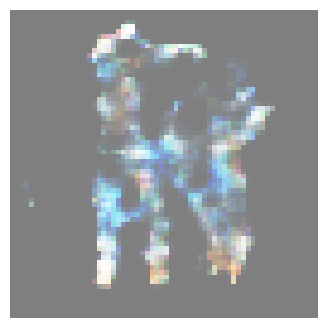

Epoch 86/140
Batch Loss: 0.0074
Batch Loss: 0.0072
Batch Loss: 0.0073
Batch Loss: 0.0078
Batch Loss: 0.0078
Batch Loss: 0.0076
Batch Loss: 0.0072
Batch Loss: 0.0069
Batch Loss: 0.0074


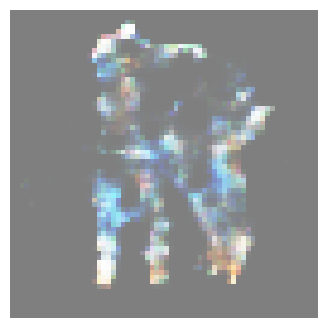

Epoch 87/140
Batch Loss: 0.0071
Batch Loss: 0.0073
Batch Loss: 0.0071
Batch Loss: 0.0073
Batch Loss: 0.0070
Batch Loss: 0.0076
Batch Loss: 0.0075
Batch Loss: 0.0066
Batch Loss: 0.0049


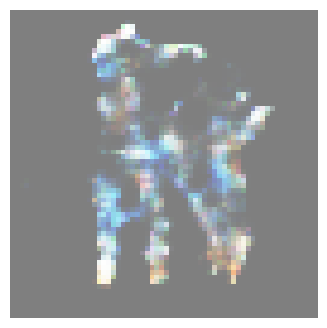

Epoch 88/140
Batch Loss: 0.0069
Batch Loss: 0.0067
Batch Loss: 0.0070
Batch Loss: 0.0075
Batch Loss: 0.0068
Batch Loss: 0.0071
Batch Loss: 0.0065
Batch Loss: 0.0066
Batch Loss: 0.0072


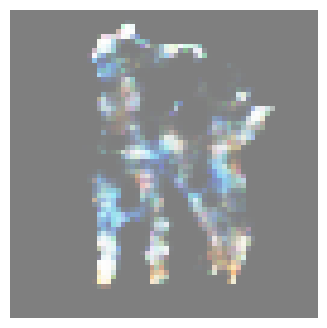

Epoch 89/140
Batch Loss: 0.0067
Batch Loss: 0.0067
Batch Loss: 0.0067
Batch Loss: 0.0072
Batch Loss: 0.0065
Batch Loss: 0.0066
Batch Loss: 0.0068
Batch Loss: 0.0066
Batch Loss: 0.0052


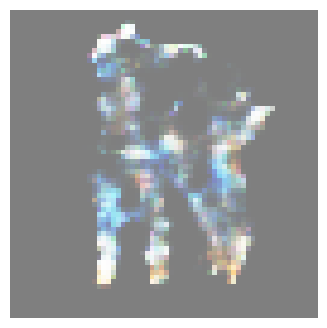

Epoch 90/140
Batch Loss: 0.0068
Batch Loss: 0.0070
Batch Loss: 0.0066
Batch Loss: 0.0067
Batch Loss: 0.0064
Batch Loss: 0.0066
Batch Loss: 0.0064
Batch Loss: 0.0062
Batch Loss: 0.0063


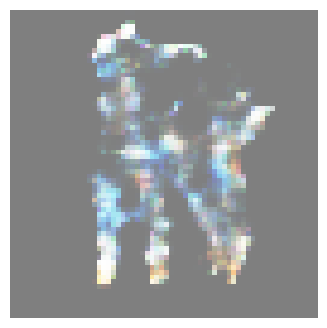

Epoch 91/140
Batch Loss: 0.0062
Batch Loss: 0.0064
Batch Loss: 0.0066
Batch Loss: 0.0066
Batch Loss: 0.0063
Batch Loss: 0.0068
Batch Loss: 0.0063
Batch Loss: 0.0065
Batch Loss: 0.0061


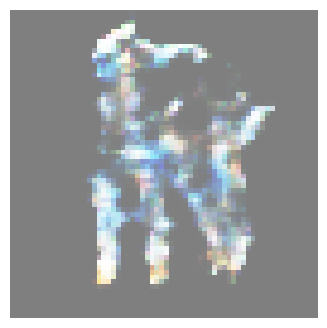

Epoch 92/140
Batch Loss: 0.0061
Batch Loss: 0.0065
Batch Loss: 0.0063
Batch Loss: 0.0061
Batch Loss: 0.0065
Batch Loss: 0.0065
Batch Loss: 0.0068
Batch Loss: 0.0059
Batch Loss: 0.0075


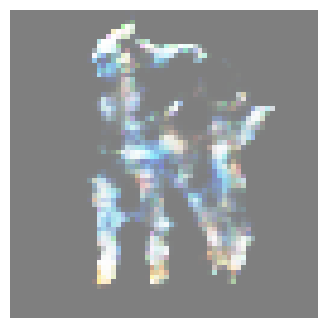

Epoch 93/140
Batch Loss: 0.0067
Batch Loss: 0.0063
Batch Loss: 0.0066
Batch Loss: 0.0063
Batch Loss: 0.0057
Batch Loss: 0.0060
Batch Loss: 0.0065
Batch Loss: 0.0062
Batch Loss: 0.0078


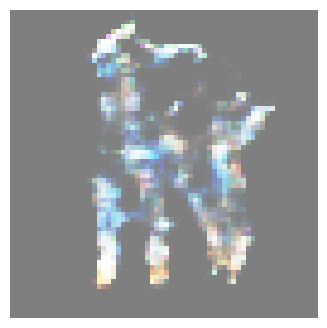

Epoch 94/140
Batch Loss: 0.0062
Batch Loss: 0.0061
Batch Loss: 0.0062
Batch Loss: 0.0064
Batch Loss: 0.0066
Batch Loss: 0.0062
Batch Loss: 0.0061
Batch Loss: 0.0059
Batch Loss: 0.0048


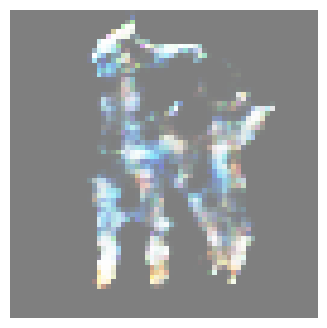

Epoch 95/140
Batch Loss: 0.0064
Batch Loss: 0.0060
Batch Loss: 0.0060
Batch Loss: 0.0062
Batch Loss: 0.0063
Batch Loss: 0.0056
Batch Loss: 0.0061
Batch Loss: 0.0062
Batch Loss: 0.0063


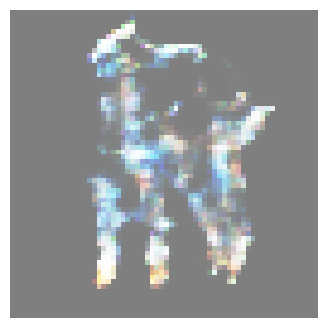

Epoch 96/140
Batch Loss: 0.0059
Batch Loss: 0.0062
Batch Loss: 0.0057
Batch Loss: 0.0058
Batch Loss: 0.0060
Batch Loss: 0.0061
Batch Loss: 0.0058
Batch Loss: 0.0063
Batch Loss: 0.0076


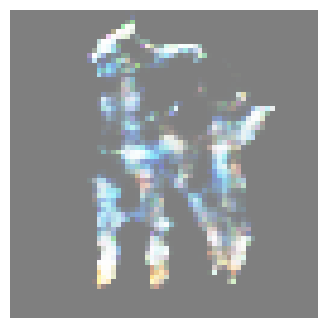

Epoch 97/140
Batch Loss: 0.0066
Batch Loss: 0.0058
Batch Loss: 0.0056
Batch Loss: 0.0058
Batch Loss: 0.0058
Batch Loss: 0.0060
Batch Loss: 0.0059
Batch Loss: 0.0059
Batch Loss: 0.0051


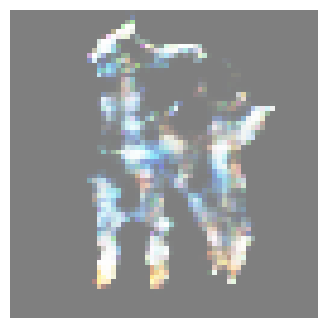

Epoch 98/140
Batch Loss: 0.0059
Batch Loss: 0.0059
Batch Loss: 0.0056
Batch Loss: 0.0057
Batch Loss: 0.0061
Batch Loss: 0.0057
Batch Loss: 0.0061
Batch Loss: 0.0058
Batch Loss: 0.0067


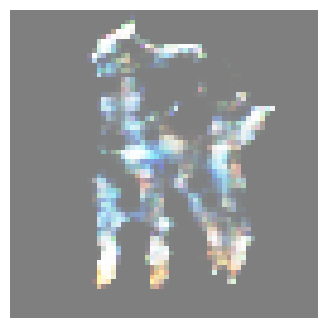

Epoch 99/140
Batch Loss: 0.0058
Batch Loss: 0.0057
Batch Loss: 0.0054
Batch Loss: 0.0064
Batch Loss: 0.0055
Batch Loss: 0.0057
Batch Loss: 0.0061
Batch Loss: 0.0062
Batch Loss: 0.0058


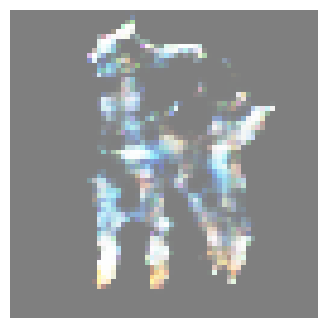

Epoch 100/140
Batch Loss: 0.0057
Batch Loss: 0.0057
Batch Loss: 0.0062
Batch Loss: 0.0060
Batch Loss: 0.0058
Batch Loss: 0.0054
Batch Loss: 0.0057
Batch Loss: 0.0056
Batch Loss: 0.0062


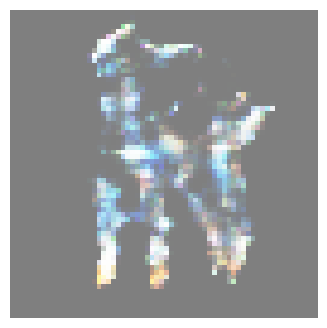

Epoch 101/140
Batch Loss: 0.0058
Batch Loss: 0.0055
Batch Loss: 0.0054
Batch Loss: 0.0060
Batch Loss: 0.0060
Batch Loss: 0.0056
Batch Loss: 0.0054
Batch Loss: 0.0059
Batch Loss: 0.0074


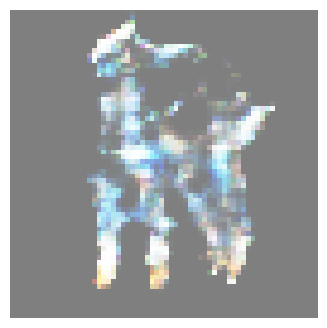

Epoch 102/140
Batch Loss: 0.0057
Batch Loss: 0.0059
Batch Loss: 0.0058
Batch Loss: 0.0059
Batch Loss: 0.0056
Batch Loss: 0.0058
Batch Loss: 0.0056
Batch Loss: 0.0057
Batch Loss: 0.0046


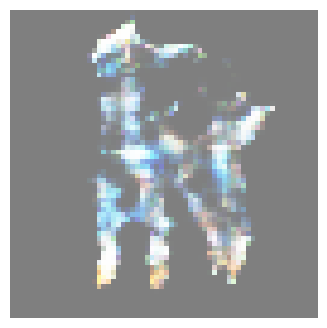

Epoch 103/140
Batch Loss: 0.0059
Batch Loss: 0.0055
Batch Loss: 0.0058
Batch Loss: 0.0054
Batch Loss: 0.0057
Batch Loss: 0.0059
Batch Loss: 0.0056
Batch Loss: 0.0056
Batch Loss: 0.0054


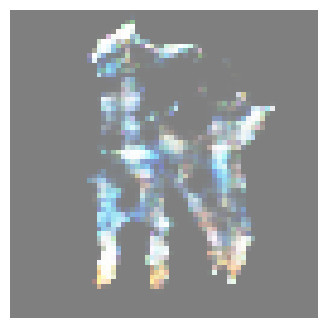

Epoch 104/140
Batch Loss: 0.0055
Batch Loss: 0.0053
Batch Loss: 0.0053
Batch Loss: 0.0052
Batch Loss: 0.0054
Batch Loss: 0.0056
Batch Loss: 0.0061
Batch Loss: 0.0058
Batch Loss: 0.0086


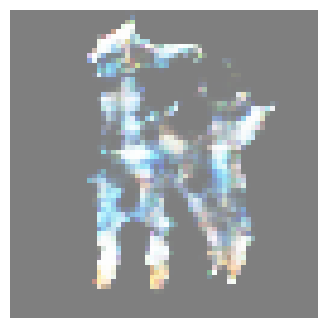

Epoch 105/140
Batch Loss: 0.0055
Batch Loss: 0.0055
Batch Loss: 0.0059
Batch Loss: 0.0048
Batch Loss: 0.0064
Batch Loss: 0.0055
Batch Loss: 0.0058
Batch Loss: 0.0059
Batch Loss: 0.0043


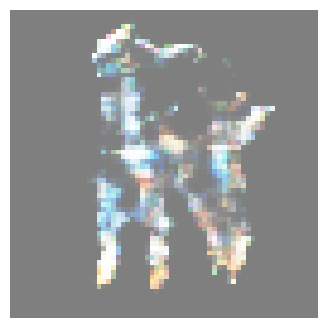

Epoch 106/140
Batch Loss: 0.0059
Batch Loss: 0.0049
Batch Loss: 0.0054
Batch Loss: 0.0055
Batch Loss: 0.0056
Batch Loss: 0.0056
Batch Loss: 0.0066
Batch Loss: 0.0055
Batch Loss: 0.0046


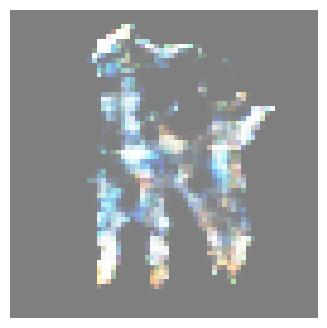

Epoch 107/140
Batch Loss: 0.0059
Batch Loss: 0.0052
Batch Loss: 0.0059
Batch Loss: 0.0053
Batch Loss: 0.0052
Batch Loss: 0.0052
Batch Loss: 0.0057
Batch Loss: 0.0052
Batch Loss: 0.0052


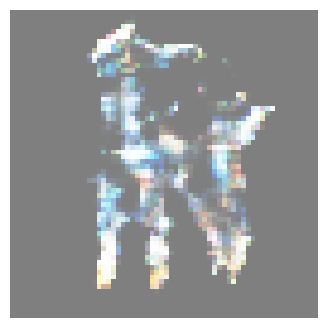

Epoch 108/140
Batch Loss: 0.0053
Batch Loss: 0.0052
Batch Loss: 0.0057
Batch Loss: 0.0052
Batch Loss: 0.0053
Batch Loss: 0.0053
Batch Loss: 0.0054
Batch Loss: 0.0052
Batch Loss: 0.0056


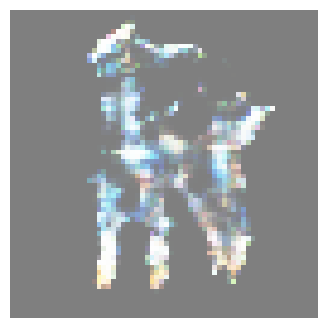

Epoch 109/140
Batch Loss: 0.0049
Batch Loss: 0.0053
Batch Loss: 0.0054
Batch Loss: 0.0055
Batch Loss: 0.0052
Batch Loss: 0.0051
Batch Loss: 0.0049
Batch Loss: 0.0056
Batch Loss: 0.0092


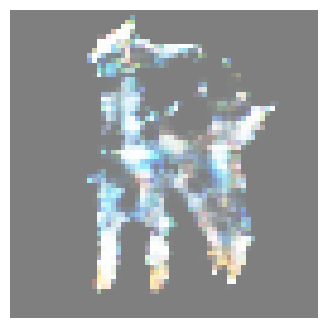

Epoch 110/140
Batch Loss: 0.0056
Batch Loss: 0.0051
Batch Loss: 0.0055
Batch Loss: 0.0057
Batch Loss: 0.0053
Batch Loss: 0.0053
Batch Loss: 0.0061
Batch Loss: 0.0052
Batch Loss: 0.0049


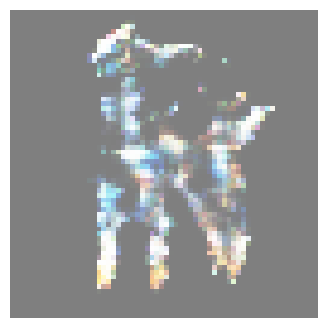

Epoch 111/140
Batch Loss: 0.0052
Batch Loss: 0.0053
Batch Loss: 0.0054
Batch Loss: 0.0060
Batch Loss: 0.0050
Batch Loss: 0.0052
Batch Loss: 0.0055
Batch Loss: 0.0053
Batch Loss: 0.0044


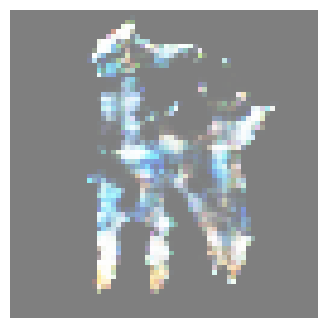

Epoch 112/140
Batch Loss: 0.0055
Batch Loss: 0.0050
Batch Loss: 0.0051
Batch Loss: 0.0051
Batch Loss: 0.0051
Batch Loss: 0.0051
Batch Loss: 0.0054
Batch Loss: 0.0055
Batch Loss: 0.0055


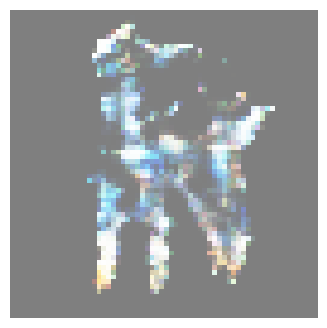

Epoch 113/140
Batch Loss: 0.0053
Batch Loss: 0.0049
Batch Loss: 0.0051
Batch Loss: 0.0053
Batch Loss: 0.0051
Batch Loss: 0.0050
Batch Loss: 0.0052
Batch Loss: 0.0052
Batch Loss: 0.0054


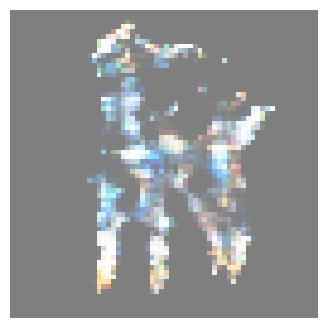

Epoch 114/140
Batch Loss: 0.0050
Batch Loss: 0.0050
Batch Loss: 0.0050
Batch Loss: 0.0050
Batch Loss: 0.0055
Batch Loss: 0.0046
Batch Loss: 0.0052
Batch Loss: 0.0048
Batch Loss: 0.0045


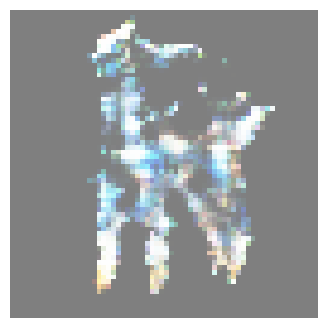

Epoch 115/140
Batch Loss: 0.0048
Batch Loss: 0.0053
Batch Loss: 0.0049
Batch Loss: 0.0047
Batch Loss: 0.0050
Batch Loss: 0.0046
Batch Loss: 0.0048
Batch Loss: 0.0048
Batch Loss: 0.0049


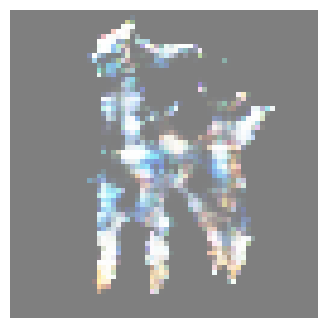

Epoch 116/140
Batch Loss: 0.0046
Batch Loss: 0.0049
Batch Loss: 0.0047
Batch Loss: 0.0047
Batch Loss: 0.0044
Batch Loss: 0.0048
Batch Loss: 0.0047
Batch Loss: 0.0051
Batch Loss: 0.0050


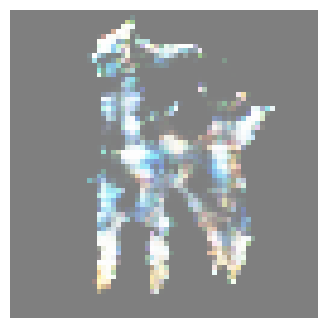

Epoch 117/140
Batch Loss: 0.0044
Batch Loss: 0.0048
Batch Loss: 0.0046
Batch Loss: 0.0045
Batch Loss: 0.0047
Batch Loss: 0.0051
Batch Loss: 0.0047
Batch Loss: 0.0041
Batch Loss: 0.0057


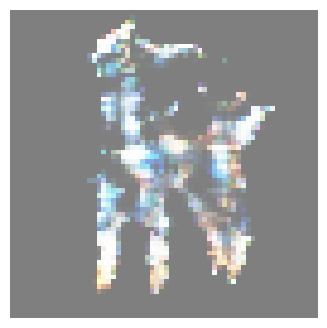

Epoch 118/140
Batch Loss: 0.0044
Batch Loss: 0.0044
Batch Loss: 0.0047
Batch Loss: 0.0044
Batch Loss: 0.0048
Batch Loss: 0.0047
Batch Loss: 0.0046
Batch Loss: 0.0045
Batch Loss: 0.0052


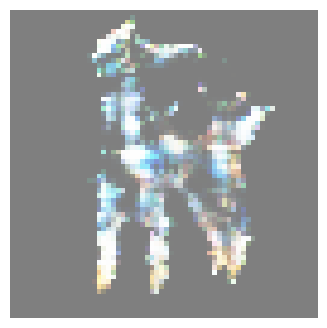

Epoch 119/140
Batch Loss: 0.0043
Batch Loss: 0.0044
Batch Loss: 0.0045
Batch Loss: 0.0044
Batch Loss: 0.0046
Batch Loss: 0.0046
Batch Loss: 0.0048
Batch Loss: 0.0044
Batch Loss: 0.0040


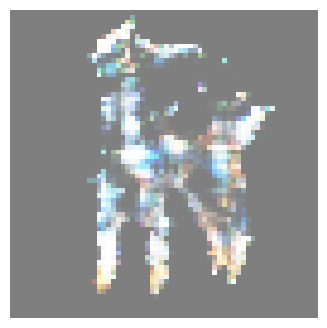

Epoch 120/140
Batch Loss: 0.0045
Batch Loss: 0.0045
Batch Loss: 0.0042
Batch Loss: 0.0045
Batch Loss: 0.0044
Batch Loss: 0.0044
Batch Loss: 0.0044
Batch Loss: 0.0046
Batch Loss: 0.0057


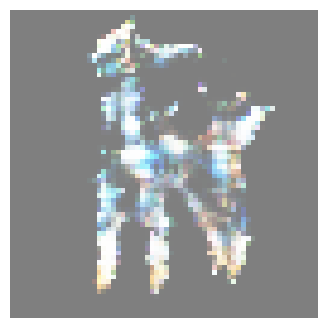

Epoch 121/140
Batch Loss: 0.0042
Batch Loss: 0.0045
Batch Loss: 0.0044
Batch Loss: 0.0041
Batch Loss: 0.0044
Batch Loss: 0.0046
Batch Loss: 0.0046
Batch Loss: 0.0043
Batch Loss: 0.0050


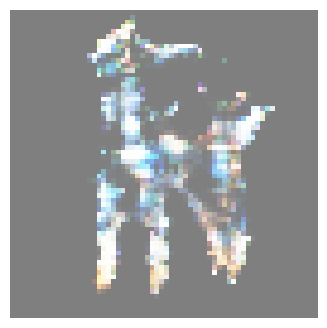

Epoch 122/140
Batch Loss: 0.0042
Batch Loss: 0.0045
Batch Loss: 0.0045
Batch Loss: 0.0039
Batch Loss: 0.0041
Batch Loss: 0.0044
Batch Loss: 0.0046
Batch Loss: 0.0043
Batch Loss: 0.0040


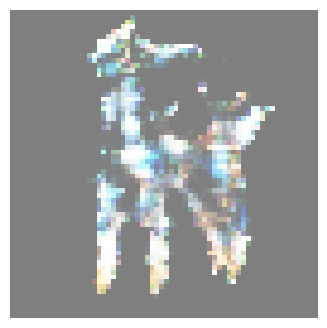

Epoch 123/140
Batch Loss: 0.0045
Batch Loss: 0.0042
Batch Loss: 0.0039
Batch Loss: 0.0040
Batch Loss: 0.0043
Batch Loss: 0.0047
Batch Loss: 0.0042
Batch Loss: 0.0041
Batch Loss: 0.0033


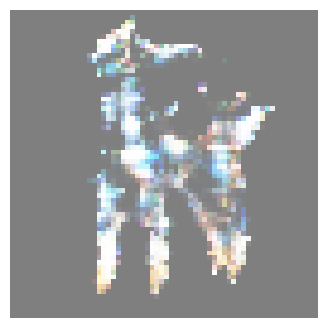

Epoch 124/140
Batch Loss: 0.0042
Batch Loss: 0.0043
Batch Loss: 0.0040
Batch Loss: 0.0040
Batch Loss: 0.0040
Batch Loss: 0.0042
Batch Loss: 0.0044
Batch Loss: 0.0045
Batch Loss: 0.0036


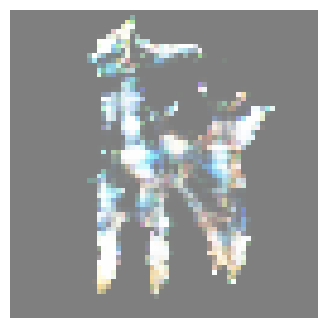

Epoch 125/140
Batch Loss: 0.0042
Batch Loss: 0.0041
Batch Loss: 0.0041
Batch Loss: 0.0043
Batch Loss: 0.0040
Batch Loss: 0.0039
Batch Loss: 0.0040
Batch Loss: 0.0044
Batch Loss: 0.0043


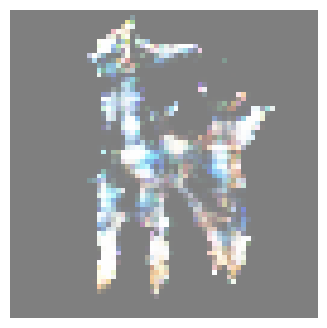

Epoch 126/140
Batch Loss: 0.0039
Batch Loss: 0.0042
Batch Loss: 0.0042
Batch Loss: 0.0042
Batch Loss: 0.0040
Batch Loss: 0.0039
Batch Loss: 0.0042
Batch Loss: 0.0045
Batch Loss: 0.0046


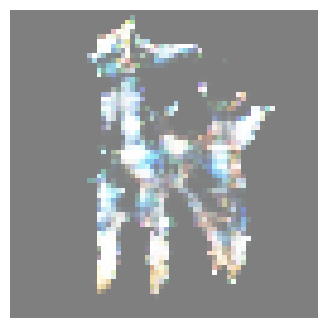

Epoch 127/140
Batch Loss: 0.0040
Batch Loss: 0.0039
Batch Loss: 0.0042
Batch Loss: 0.0041
Batch Loss: 0.0042
Batch Loss: 0.0042
Batch Loss: 0.0042
Batch Loss: 0.0041
Batch Loss: 0.0048


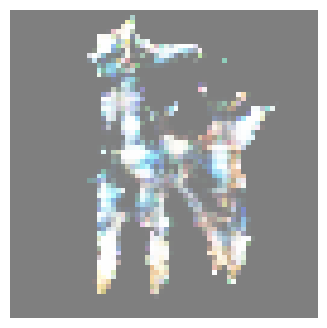

Epoch 128/140
Batch Loss: 0.0039
Batch Loss: 0.0038
Batch Loss: 0.0042
Batch Loss: 0.0039
Batch Loss: 0.0042
Batch Loss: 0.0042
Batch Loss: 0.0046
Batch Loss: 0.0041
Batch Loss: 0.0053


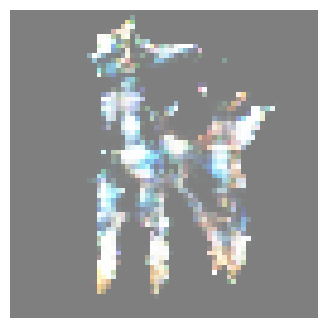

Epoch 129/140
Batch Loss: 0.0042
Batch Loss: 0.0041
Batch Loss: 0.0044
Batch Loss: 0.0042
Batch Loss: 0.0040
Batch Loss: 0.0043
Batch Loss: 0.0042
Batch Loss: 0.0040
Batch Loss: 0.0033


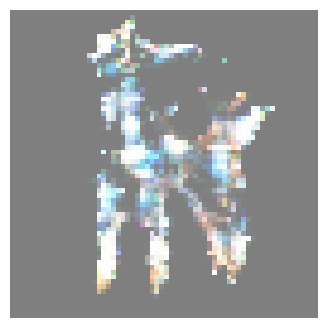

Epoch 130/140
Batch Loss: 0.0040
Batch Loss: 0.0040
Batch Loss: 0.0040
Batch Loss: 0.0044
Batch Loss: 0.0040
Batch Loss: 0.0040
Batch Loss: 0.0043
Batch Loss: 0.0041
Batch Loss: 0.0042


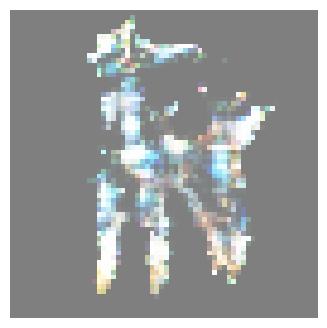

Epoch 131/140
Batch Loss: 0.0039
Batch Loss: 0.0041
Batch Loss: 0.0040
Batch Loss: 0.0040
Batch Loss: 0.0041
Batch Loss: 0.0044
Batch Loss: 0.0042
Batch Loss: 0.0040
Batch Loss: 0.0035


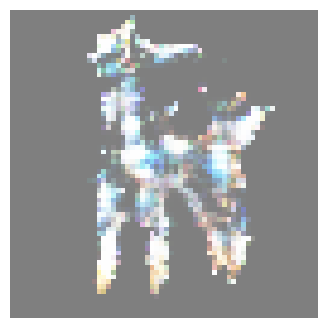

Epoch 132/140
Batch Loss: 0.0045
Batch Loss: 0.0036
Batch Loss: 0.0041
Batch Loss: 0.0038
Batch Loss: 0.0042
Batch Loss: 0.0039
Batch Loss: 0.0041
Batch Loss: 0.0040
Batch Loss: 0.0034


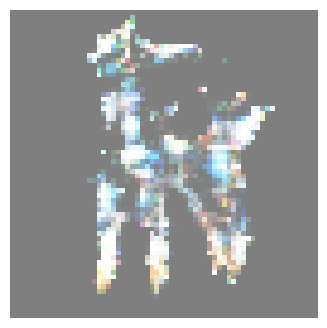

Epoch 133/140
Batch Loss: 0.0040
Batch Loss: 0.0040
Batch Loss: 0.0040
Batch Loss: 0.0037
Batch Loss: 0.0041
Batch Loss: 0.0039
Batch Loss: 0.0040
Batch Loss: 0.0041
Batch Loss: 0.0037


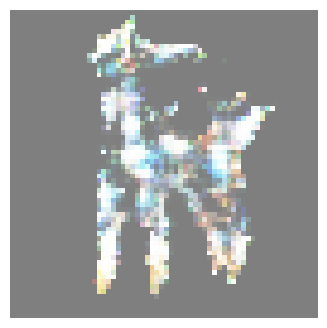

Epoch 134/140
Batch Loss: 0.0040
Batch Loss: 0.0036
Batch Loss: 0.0040
Batch Loss: 0.0042
Batch Loss: 0.0039
Batch Loss: 0.0043
Batch Loss: 0.0038
Batch Loss: 0.0040
Batch Loss: 0.0038


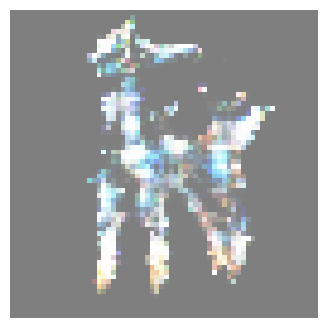

Epoch 135/140
Batch Loss: 0.0037
Batch Loss: 0.0039
Batch Loss: 0.0038
Batch Loss: 0.0038
Batch Loss: 0.0043
Batch Loss: 0.0040
Batch Loss: 0.0038
Batch Loss: 0.0043
Batch Loss: 0.0038


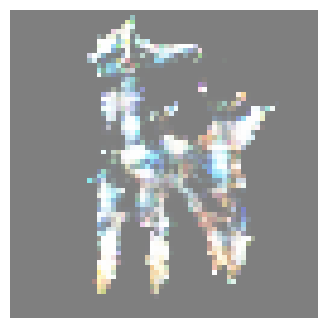

Epoch 136/140
Batch Loss: 0.0037
Batch Loss: 0.0038
Batch Loss: 0.0038
Batch Loss: 0.0040
Batch Loss: 0.0036
Batch Loss: 0.0040
Batch Loss: 0.0038
Batch Loss: 0.0042
Batch Loss: 0.0042


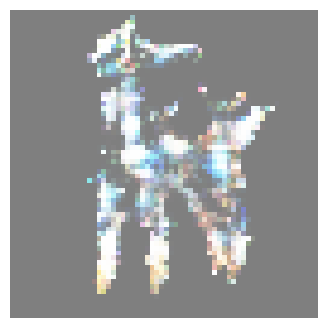

Epoch 137/140
Batch Loss: 0.0036
Batch Loss: 0.0037
Batch Loss: 0.0038
Batch Loss: 0.0039
Batch Loss: 0.0038
Batch Loss: 0.0040
Batch Loss: 0.0037
Batch Loss: 0.0042
Batch Loss: 0.0029


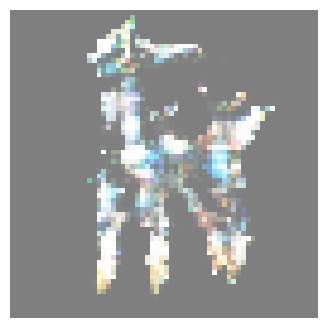

Epoch 138/140
Batch Loss: 0.0037
Batch Loss: 0.0036
Batch Loss: 0.0038
Batch Loss: 0.0037
Batch Loss: 0.0038
Batch Loss: 0.0035
Batch Loss: 0.0037
Batch Loss: 0.0042
Batch Loss: 0.0043


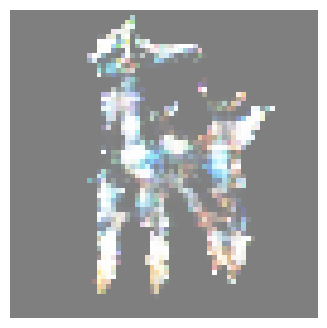

Epoch 139/140
Batch Loss: 0.0038
Batch Loss: 0.0038
Batch Loss: 0.0036
Batch Loss: 0.0037
Batch Loss: 0.0039
Batch Loss: 0.0038
Batch Loss: 0.0037
Batch Loss: 0.0034
Batch Loss: 0.0037


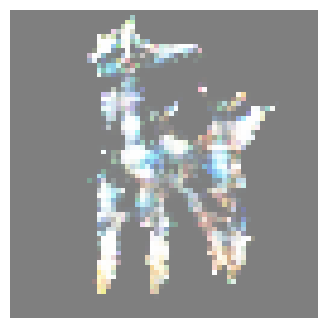

Epoch 140/140
Batch Loss: 0.0043
Batch Loss: 0.0034
Batch Loss: 0.0038
Batch Loss: 0.0035
Batch Loss: 0.0036
Batch Loss: 0.0036
Batch Loss: 0.0037
Batch Loss: 0.0034
Batch Loss: 0.0034


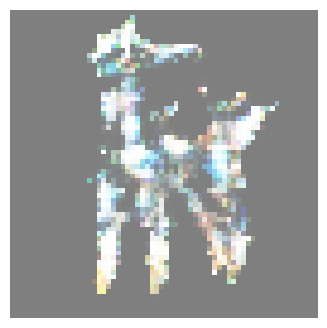

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image as kimage

image1_path = './images/arceus.png'
image2_path = './images/arceus.png'

# Function to display interpolated images
def display_interpolated_images(model, image1, image2, num_steps=10, epoch=-1):
    interpolated_images = interpolate(model, image1, image2, num_steps)
    plt.figure(figsize=(12, 4))
    for i, img in enumerate(interpolated_images):
        plt.subplot(1, num_steps, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.savefig("./timelapse/"+str(epoch))  # save the figure before showing it
    plt.show()  # show the figure after saving it

# Step 4: Implement the training loop
latent_dim = 2048  # Set the desired latent dimension
vae = VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam()

epochs = 140
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for images, _ in dataset:
        with tf.GradientTape() as tape:
            reconstructed_images = vae(images)
            loss = mse_loss(images, reconstructed_images)

        gradients = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))



        print(f"Batch Loss: {loss.numpy():.4f}")
    # Display interpolated images after each epoch
    display_interpolated_images(vae, image1_path, image2_path, 1, epoch=epoch)


In [11]:
# Step 5: Save the trained model
vae.save_weights("vae_weights.h5")

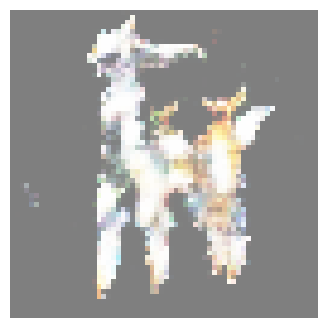

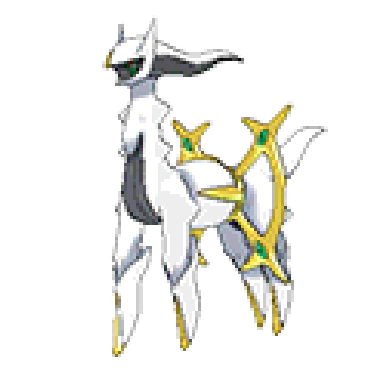

In [12]:
image1_path = './images/arceus.png'
image2_path = './images/arceus.png'
display_interpolated_images(vae, image1_path, image2_path, 1)

import matplotlib.pyplot as plt

# Provide the path to the image file
image_path = image1_path

# Read and display the image
image = plt.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()


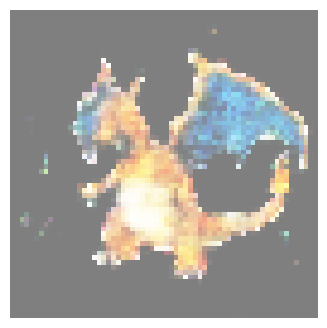

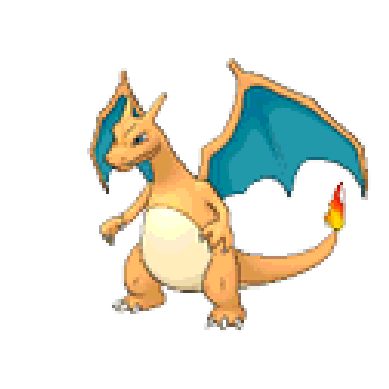

In [41]:
image1_path = './images/charizard.png'
image2_path = './images/charizard.png'
display_interpolated_images(vae, image1_path, image2_path, 1)

# Provide the path to the image file
image_path = image1_path

# Read and display the image
image = plt.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

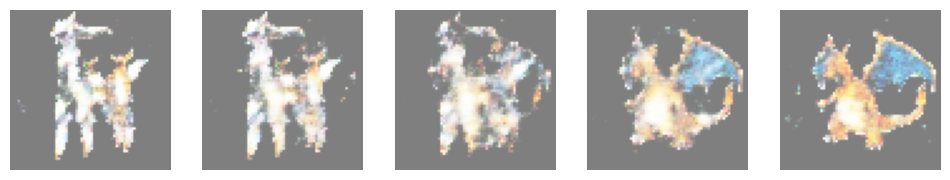

<Figure size 640x480 with 0 Axes>

In [42]:
image1_path = './images/arceus.png'
image2_path = './images/charizard.png'
display_interpolated_images(vae, image1_path, image2_path, num_steps=5)

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
!zip -r ./timelapse.zip ./timelapse

updating: timelapse/ (stored 0%)
updating: timelapse/57.png (deflated 16%)
updating: timelapse/89.png (deflated 27%)
updating: timelapse/58.png (deflated 16%)
updating: timelapse/107.png (deflated 28%)
updating: timelapse/138.png (deflated 27%)
updating: timelapse/70.png (deflated 18%)
updating: timelapse/84.png (deflated 26%)
updating: timelapse/80.png (deflated 27%)
updating: timelapse/67.png (deflated 31%)
updating: timelapse/23.png (deflated 21%)
updating: timelapse/1.png (deflated 31%)
updating: timelapse/12.png (deflated 35%)
updating: timelapse/42.png (deflated 21%)
updating: timelapse/90.png (deflated 26%)
updating: timelapse/34.png (deflated 20%)
updating: timelapse/62.png (deflated 17%)
updating: timelapse/53.png (deflated 16%)
updating: timelapse/18.png (deflated 21%)
updating: timelapse/128.png (deflated 28%)
updating: timelapse/104.png (deflated 27%)
updating: timelapse/100.png (deflated 26%)
updating: timelapse/87.png (deflated 27%)
updating: timelapse/101.png (deflated 2

In [48]:
from google.colab import files
files.download("./timelapse.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We continue training